In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz

In [ ]:
!tar -xvf spark-2.4.5-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

**Домашнее задание**

2 варианта.

Вариант легкий: 
Решите задачу классификации цветков ирисов с использованием PySpark

Вариант сложный: 
Решите задачу классификации пассажиров титаника с использованием PySpark (https://www.kaggle.com/c/titanic)

При выполнении ДЗ не разрешается:
* Использовать библиотеку pandas
* Использовать библиотеку sklearn

Полезные импорты:
* from pyspark.ml.classification import LogisticRegression
* from pyspark.ml.evaluation import MulticlassClassificationEvaluator - для оценки качества работы алгоритма
* from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler - для предобработки признаков

Полезные ссылки:

https://spark.apache.org/docs/latest/ml-classification-regression.html#classification - алгоримты классификации в pyspark

https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa - пример решения задачи классификации на pyspark

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler # для предобработки признаков
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator # для оценки качества работы алгоритма
from pyspark.sql.functions import mean, when, lit
import pyspark.sql.functions as f


**Titanic Dataset**

In [ ]:
# массив уже разделен на обучающую выборку и выборку для проверки модели:
train = spark.read.csv('train.csv', inferSchema=True, header=True)
test = spark.read.csv('test.csv', inferSchema=True, header=True)

In [ ]:
train.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



* Survived: выживание (0 = нет; 1 = да)
* Pclass:	класс, которым следовал пассажир (1 = 1st (upper); 2 = 2nd (middle); 3 = 3rd (lower))
* Name:	имя
* Sex:	пол
* Age: возраст
* SibS:	количество братьев (сестер) / супругов на борту
* Parch:	количество родителей / детей на борту
* Ticket:	номер билета
* Fare:	пассажирский тариф
* Cabin:	номер каюты
* Embarked: порт посадки (C = Cherbourg; Q = Queenstown; S = Southampton)


In [ ]:
train.show(3)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
only showing top 3 rows



In [ ]:
test.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [ ]:
test.show(3)

+-----------+------+--------------------+------+----+-----+-----+------+------+-----+--------+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch|Ticket|  Fare|Cabin|Embarked|
+-----------+------+--------------------+------+----+-----+-----+------+------+-----+--------+
|        892|     3|    Kelly, Mr. James|  male|34.5|    0|    0|330911|7.8292| null|       Q|
|        893|     3|Wilkes, Mrs. Jame...|female|47.0|    1|    0|363272|   7.0| null|       S|
|        894|     2|Myles, Mr. Thomas...|  male|62.0|    0|    0|240276|9.6875| null|       Q|
+-----------+------+--------------------+------+----+-----+-----+------+------+-----+--------+
only showing top 3 rows



Missing values

In [ ]:
# для обучающей выборки основные статистики и наличие пропущенных значений (null)
train.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                null|  null| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

In [ ]:
# пропущенные значения содержатся в столбцах Age, Cabin, Embarked, можно вывести их количество:
train_agg = train.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in train.columns]) # кол-во значений null по столбцам
train_agg.show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [ ]:
# выживаемость пассажиров зависит от класса каюты:
survived_pclass = train.groupby('Pclass').pivot('Survived').count()
survived_pclass.show()

+------+---+---+
|Pclass|  0|  1|
+------+---+---+
|     1| 80|136|
|     3|372|119|
|     2| 97| 87|
+------+---+---+



In [ ]:
survived_pclass.withColumn('percent', survived_pclass['1']/(survived_pclass['0']+survived_pclass['1']))\
.orderBy('percent', ascending=False).show()
# или:
# survived_pclass.withColumn('total', sum(survived_pclass[col] for col in survived_pclass.columns))\
# .withColumn('percent', f.col('1')/f.col('total'))\
# .orderBy('percent', ascending=False).show()

+------+---+---+-------------------+
|Pclass|  0|  1|            percent|
+------+---+---+-------------------+
|     1| 80|136| 0.6296296296296297|
|     2| 97| 87|0.47282608695652173|
|     3|372|119|0.24236252545824846|
+------+---+---+-------------------+



In [ ]:
# выживаемость пассажиров зависит от пола:
survived_sex = train.groupby('Sex').pivot('Survived').count()
survived_sex.show()

+------+---+---+
|   Sex|  0|  1|
+------+---+---+
|female| 81|233|
|  male|468|109|
+------+---+---+



In [ ]:
survived_sex.withColumn('percent', survived_sex['1']/(survived_sex['0']+survived_sex['1'])).show()

+------+---+---+-------------------+
|   Sex|  0|  1|            percent|
+------+---+---+-------------------+
|female| 81|233| 0.7420382165605095|
|  male|468|109|0.18890814558058924|
+------+---+---+-------------------+



In [ ]:
#  рассчитаем ср. возраст в зависимости от пола пассажиров и класса каюты, чтобы заместить пропущенные значения:
train.groupBy('Pclass', 'Sex').agg({'Age': 'mean'}).orderBy('Pclass','Sex').show()

+------+------+------------------+
|Pclass|   Sex|          avg(Age)|
+------+------+------------------+
|     1|female| 34.61176470588235|
|     1|  male| 41.28138613861386|
|     2|female|28.722972972972972|
|     2|  male| 30.74070707070707|
|     3|female|             21.75|
|     3|  male|26.507588932806325|
+------+------+------------------+



In [ ]:
# заменяем пропущенные значения Age, создав новую колонку: 
train_ = train.withColumn('Age_', f.when((f.col('Age').isNull()) & (f.col('Pclass') == 1) & (f.col('Sex') == 'female'), 34.6)\
                          .when((f.col('Age').isNull()) & (f.col('Pclass') == 1) & (f.col('Sex') == 'male'), 41.3)\
                          .when((f.col('Age').isNull()) & (f.col('Pclass') == 2) & (f.col('Sex') == 'female'), 28.7)\
                          .when((f.col('Age').isNull()) & (f.col('Pclass') == 2) & (f.col('Sex') == 'male'), 30.7)\
                          .when((f.col('Age').isNull()) & (f.col('Pclass') == 3) & (f.col('Sex') == 'female'), 21.8)\
                          .when((f.col('Age').isNull()) & (f.col('Pclass') == 3) & (f.col('Sex') == 'male'), 26.5)\
                          .otherwise(f.col('Age')))
train_.where((train_['Age'].isNull())).show()

+-----------+--------+------+--------------------+------+----+-----+-----+---------------+--------+-----+--------+----+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|         Ticket|    Fare|Cabin|Embarked|Age_|
+-----------+--------+------+--------------------+------+----+-----+-----+---------------+--------+-----+--------+----+
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|         330877|  8.4583| null|       Q|26.5|
|         18|       1|     2|Williams, Mr. Cha...|  male|null|    0|    0|         244373|    13.0| null|       S|30.7|
|         20|       1|     3|Masselmani, Mrs. ...|female|null|    0|    0|           2649|   7.225| null|       C|21.8|
|         27|       0|     3|Emir, Mr. Farred ...|  male|null|    0|    0|           2631|   7.225| null|       C|26.5|
|         29|       1|     3|"O'Dwyer, Miss. E...|female|null|    0|    0|         330959|  7.8792| null|       Q|21.8|
|         30|       0|     3| Todoroff, 

In [ ]:
# наиболее распространненый среди пассажиров порт посадки (Embarked): S = Southampton
train.groupby('Embarked').count().orderBy('count', ascending=False).first()[0]

'S'

In [ ]:
train_ = train_.withColumn('Embarked_', f.when(f.col('Embarked').isNull(), 'S').otherwise(f.col('Embarked')))

In [ ]:
train_.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+------------------+---------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|              Age_|Embarked_|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+------------------+---------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|               891|      891|
|   mean|            446.0| 0.3838383838383838| 2.30864197530864

In [ ]:
# есть еще и Fare = 0, но неизвестно, является ли это ошибкой, поэтому оставляем без изменений
train.where((train['Fare'] == 0)).count()
# train.where((train['Fare'] == 0)).show()

15

In [ ]:
# для тестовой выборки основные статистики и полнота данных:
test.describe().show()

+-------+------------------+------------------+--------------------+------+------------------+------------------+------------------+------------------+------------------+-----+--------+
|summary|       PassengerId|            Pclass|                Name|   Sex|               Age|             SibSp|             Parch|            Ticket|              Fare|Cabin|Embarked|
+-------+------------------+------------------+--------------------+------+------------------+------------------+------------------+------------------+------------------+-----+--------+
|  count|               418|               418|                 418|   418|               332|               418|               418|               418|               417|   91|     418|
|   mean|            1100.5|2.2655502392344498|                null|  null|30.272590361445783|0.4473684210526316|0.3923444976076555|223850.98986486485|  35.6271884892086| null|    null|
| stddev|120.81045760473994|0.8418375519640503|                null|  

In [ ]:
test_agg = test.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in test.columns])
test_agg.show()

+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|     0|   0|  0| 86|    0|    0|     0|   1|  327|       0|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+



In [ ]:
test.groupBy('Pclass', 'Sex').agg({'Age': 'mean'}).orderBy('Pclass','Sex').show()

+------+------+------------------+
|Pclass|   Sex|          avg(Age)|
+------+------+------------------+
|     1|female|41.333333333333336|
|     1|  male|             40.52|
|     2|female|24.376551724137933|
|     2|  male|30.940677966101696|
|     3|female|23.073400000000003|
|     3|  male|24.525104166666665|
+------+------+------------------+



In [ ]:
test_ = test.withColumn('Age_', f.when((f.col('Age').isNull()) & (f.col('Pclass') == 1) & (f.col('Sex') == 'female'), 41.3)\
                          .when((f.col('Age').isNull()) & (f.col('Pclass') == 1) & (f.col('Sex') == 'male'), 40.5)\
                          .when((f.col('Age').isNull()) & (f.col('Pclass') == 2) & (f.col('Sex') == 'female'), 24.4)\
                          .when((f.col('Age').isNull()) & (f.col('Pclass') == 2) & (f.col('Sex') == 'male'), 30.9)\
                          .when((f.col('Age').isNull()) & (f.col('Pclass') == 3) & (f.col('Sex') == 'female'), 23.1)\
                          .when((f.col('Age').isNull()) & (f.col('Pclass') == 3) & (f.col('Sex') == 'male'), 24.5)\
                          .otherwise(f.col('Age')))
test_.where((test_['Age'].isNull())).show()

+-----------+------+--------------------+------+----+-----+-----+------------+-------+-----+--------+----+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch|      Ticket|   Fare|Cabin|Embarked|Age_|
+-----------+------+--------------------+------+----+-----+-----+------------+-------+-----+--------+----+
|        902|     3|    Ilieff, Mr. Ylio|  male|null|    0|    0|      349220| 7.8958| null|       S|24.5|
|        914|     1|Flegenheim, Mrs. ...|female|null|    0|    0|    PC 17598|31.6833| null|       S|41.3|
|        921|     3|   Samaan, Mr. Elias|  male|null|    2|    0|        2662|21.6792| null|       C|24.5|
|        925|     3|"Johnston, Mrs. A...|female|null|    1|    2|  W./C. 6607|  23.45| null|       S|23.1|
|        928|     3| Roth, Miss. Sarah A|female|null|    0|    0|      342712|   8.05| null|       S|23.1|
|        931|     3|       Hee, Mr. Ling|  male|null|    0|    0|        1601|56.4958| null|       S|24.5|
|        933|     1|Franklin, Mr. Tho

In [ ]:
# тариф, вероятно, зависит от класса каюты и порта отправления; рассчитаем ср. значение:
test.groupBy('Pclass', 'Embarked').agg({'Fare': 'mean'}).orderBy('Embarked','Pclass').show()

+------+--------+------------------+
|Pclass|Embarked|         avg(Fare)|
+------+--------+------------------+
|     1|       C|110.07351071428572|
|     2|       C|20.120445454545457|
|     3|       C|           10.6587|
|     1|       Q|              90.0|
|     2|       Q|11.273950000000001|
|     3|       Q| 8.998985365853658|
|     1|       S| 76.67750400000001|
|     2|       S|23.056089743589745|
|     3|       S| 13.91302978723404|
+------+--------+------------------+



In [ ]:
# строки с пропущенными значениями:
test_.where((test_['Fare'].isNull())).show()

+-----------+------+------------------+----+----+-----+-----+------+----+-----+--------+----+
|PassengerId|Pclass|              Name| Sex| Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|Age_|
+-----------+------+------------------+----+----+-----+-----+------+----+-----+--------+----+
|       1044|     3|Storey, Mr. Thomas|male|60.5|    0|    0|  3701|null| null|       S|60.5|
+-----------+------+------------------+----+----+-----+-----+------+----+-----+--------+----+



In [ ]:
# заполняем пропущенные значения:
test_ = test_.withColumn('Fare_', f.when((f.col('Fare').isNull()) & (f.col('Pclass') == 3)  & (f.col('Embarked') == 'S'), 13.91)\
                          .otherwise(f.col('Fare')))
# или по PassengerId (предвартельно убедившись, что нет дублей):
# test_ = test_.withColumn('Fare_', f.when(test_['PassengerId'] == 1044, 13.91).otherwise(f.col('Fare')))

In [ ]:
test_.where(test_['PassengerId'] == 1044).show()
# test_.where((test_['Fare'].isNull())).show()

+-----------+------+------------------+----+----+-----+-----+------+----+-----+--------+----+-----+
|PassengerId|Pclass|              Name| Sex| Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|Age_|Fare_|
+-----------+------+------------------+----+----+-----+-----+------+----+-----+--------+----+-----+
|       1044|     3|Storey, Mr. Thomas|male|60.5|    0|    0|  3701|null| null|       S|60.5|13.91|
+-----------+------+------------------+----+----+-----+-----+------+----+-----+--------+----+-----+



In [ ]:
# также есть нулевые значения Fare
test.where((test['Fare'] == 0)).count()

2

In [ ]:
test_.describe().show()

+-------+------------------+------------------+--------------------+------+------------------+------------------+------------------+------------------+------------------+-----+--------+-----------------+-----------------+
|summary|       PassengerId|            Pclass|                Name|   Sex|               Age|             SibSp|             Parch|            Ticket|              Fare|Cabin|Embarked|             Age_|            Fare_|
+-------+------------------+------------------+--------------------+------+------------------+------------------+------------------+------------------+------------------+-----+--------+-----------------+-----------------+
|  count|               418|               418|                 418|   418|               332|               418|               418|               418|               417|   91|     418|              418|              418|
|   mean|            1100.5|2.2655502392344498|                null|  null|30.272590361445783|0.4473684210526316

In [ ]:
from pyspark.sql.functions import col

In [ ]:
# оставляем только нужные столбцы (для учебного примера пренебрегаем возможным влиянием на выживаемость таких переменных как Cabin, Name, Ticket)
train_ml = train_.select(col('Pclass'), col('Sex'), col('Age_').alias('Age'), col('SibSp'), col('Parch'), col('Fare'), col('Embarked_').alias('Embarked'), col('Survived'))
train_ml.show(3)

+------+------+----+-----+-----+-------+--------+--------+
|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|Survived|
+------+------+----+-----+-----+-------+--------+--------+
|     3|  male|22.0|    1|    0|   7.25|       S|       0|
|     1|female|38.0|    1|    0|71.2833|       C|       1|
|     3|female|26.0|    0|    0|  7.925|       S|       1|
+------+------+----+-----+-----+-------+--------+--------+
only showing top 3 rows



In [ ]:
# test_.show(3)

In [ ]:
# в тестовой выборке отсутсвует столбец Survived, добавляем его
test_ = test_.withColumn('Survived', lit(0))

In [ ]:
test_ml = test_.select(col('Pclass'), col('Sex'), col('Age_').alias('Age'), col('SibSp'), col('Parch'), col('Fare_').alias('Fare'), col('Embarked'), col('Survived'))
test_ml.show(1)

+------+----+----+-----+-----+------+--------+--------+
|Pclass| Sex| Age|SibSp|Parch|  Fare|Embarked|Survived|
+------+----+----+-----+-----+------+--------+--------+
|     3|male|34.5|    0|    0|7.8292|       Q|       0|
+------+----+----+-----+-----+------+--------+--------+
only showing top 1 row



Preparing Data for Machine Learning

In [ ]:
train_ml.printSchema()

root
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Survived: integer (nullable = true)



In [ ]:
cols = train_ml.columns

In [ ]:
# from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

categoricalColumns = ['Sex', 'Embarked']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'Survived', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

Pipeline

In [ ]:
# from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train_ml)
df = pipelineModel.transform(train_ml)
selectedCols = ['label', 'features'] + cols
train = df.select(selectedCols)
train.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Survived: integer (nullable = true)



In [ ]:
train.show(5)

+-----+--------------------+------+------+----+-----+-----+-------+--------+--------+
|label|            features|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|Survived|
+-----+--------------------+------+------+----+-----+-----+-------+--------+--------+
|  0.0|[1.0,1.0,0.0,3.0,...|     3|  male|22.0|    1|    0|   7.25|       S|       0|
|  1.0|[0.0,0.0,1.0,1.0,...|     1|female|38.0|    1|    0|71.2833|       C|       1|
|  1.0|(8,[1,3,4,7],[1.0...|     3|female|26.0|    0|    0|  7.925|       S|       1|
|  1.0|[0.0,1.0,0.0,1.0,...|     1|female|35.0|    1|    0|   53.1|       S|       1|
|  0.0|[1.0,1.0,0.0,3.0,...|     3|  male|35.0|    0|    0|   8.05|       S|       0|
+-----+--------------------+------+------+----+-----+-----+-------+--------+--------+
only showing top 5 rows



In [ ]:
pipeline1 = Pipeline(stages = stages)
pipelineModel1 = pipeline1.fit(test_ml)
df1 = pipelineModel1.transform(test_ml)
selectedCols = ['label', 'features'] + cols
test = df1.select(selectedCols)
test.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Survived: integer (nullable = false)



In [ ]:
test.show(5)

+-----+--------------------+------+------+----+-----+-----+-------+--------+--------+
|label|            features|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|Survived|
+-----+--------------------+------+------+----+-----+-----+-------+--------+--------+
|  0.0|(8,[0,3,4,7],[1.0...|     3|  male|34.5|    0|    0| 7.8292|       Q|       0|
|  0.0|[0.0,1.0,0.0,3.0,...|     3|female|47.0|    1|    0|    7.0|       S|       0|
|  0.0|(8,[0,3,4,7],[1.0...|     2|  male|62.0|    0|    0| 9.6875|       Q|       0|
|  0.0|[1.0,1.0,0.0,3.0,...|     3|  male|27.0|    0|    0| 8.6625|       S|       0|
|  0.0|[0.0,1.0,0.0,3.0,...|     3|female|22.0|    1|    1|12.2875|       S|       0|
+-----+--------------------+------+------+----+-----+-----+-------+--------+--------+
only showing top 5 rows



Logistic Regression Model

In [ ]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

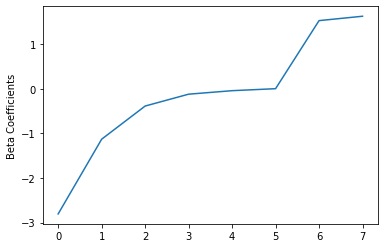

In [ ]:
# We can obtain the coefficients by using LogisticRegressionModel’s attributes.
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

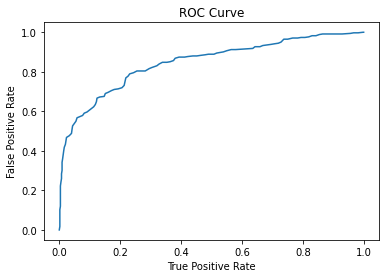

Training set areaUnderROC: 0.8459426495808433


In [ ]:
#  Summarize the model over the training set, we can also obtain the receiver-operating characteristic and areaUnderROC.
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas() 
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

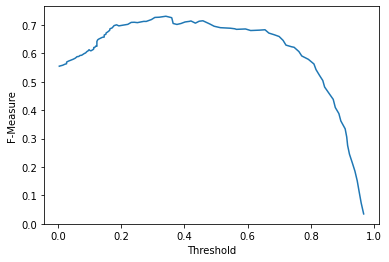

In [ ]:
# Precision and Recall
f = trainingSummary.fMeasureByThreshold.toPandas() # AttributeError: 'LogisticRegressionTrainingSummary' object has no attribute 'fMeasureByThreshold'
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

Make predictions on the test set

In [ ]:
predictions = lrModel.transform(test)
predictions.show(10)

+-----+--------------------+------+------+----+-----+-----+-------+--------+--------+--------------------+--------------------+----------+
|label|            features|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|Survived|       rawPrediction|         probability|prediction|
+-----+--------------------+------+------+----+-----+-----+-------+--------+--------+--------------------+--------------------+----------+
|  0.0|(8,[0,3,4,7],[1.0...|     3|  male|34.5|    0|    0| 7.8292|       Q|       0|[3.94177506301940...|[0.98095599155573...|       0.0|
|  0.0|[0.0,1.0,0.0,3.0,...|     3|female|47.0|    1|    0|    7.0|       S|       0|[0.45499502303953...|[0.61182618699964...|       0.0|
|  0.0|(8,[0,3,4,7],[1.0...|     2|  male|62.0|    0|    0| 9.6875|       Q|       0|[4.02389267516645...|[0.98243097494281...|       0.0|
|  0.0|[1.0,1.0,0.0,3.0,...|     3|  male|27.0|    0|    0| 8.6625|       S|       0|[1.98714635951585...|[0.87944090890554...|       0.0|
|  0.0|[0.0,1.0,0.0,3.0,...

In [ ]:
evaluator = MulticlassClassificationEvaluator()
print('Test Area Under ROC', '%.3f' % evaluator.evaluate(predictions))

Test Area Under ROC 0.809


In [ ]:
# для варианта замены ср. возраста средним для класса каюты (без учета пола пассажира) : Test Area Under ROC 0.7830761787000697